In [1]:
student_id = '20221555'
model_name = 'MicroUNetv6'

In [2]:
from competition_utils import *
from training_args import *
import time

start_time = time.time()

model_name = f'submission_{model_name}'
module_path = f"models.submission_{student_id}.{model_name}"
module = importlib.import_module(module_path)
globals()[model_name] = getattr(module, model_name)

Project_Name = 'Competition'
model_dir = 'models'
output_root = 'output'

SAVE_RESULT = True
SAVE_N = 1500
vis_root = f'vis/TEST_OUTPUTS_{datetime.now().strftime("%y%m%d_%H%M%S")}'

Dataset_root = 'Datasets'
Dataset_Name_list = [
                     'VOC',
                     'ETIS',
                     'CVPPP',
                     'CFD',
                     'CarDD',
]
number_of_classes_dict = {'VOC':21,
                          'ETIS':2,
                          'CVPPP':2,
                          'CFD':2,
                          'CarDD':2
                         }
epochs = 30
EARLY_STOP = 100
batch_size = 16
EXCLUDE_BACKGROUND = True
BINARY_SEG = None
THRESHOLD = 0.5
device = "cuda" if torch.cuda.is_available() else "cpu"

=== Learning Rate 변화 분석 시작 ===
📊 Learning Rate 변화 계산 중...
✅ 30 epoch 동안의 Learning Rate 변화 계산 완료


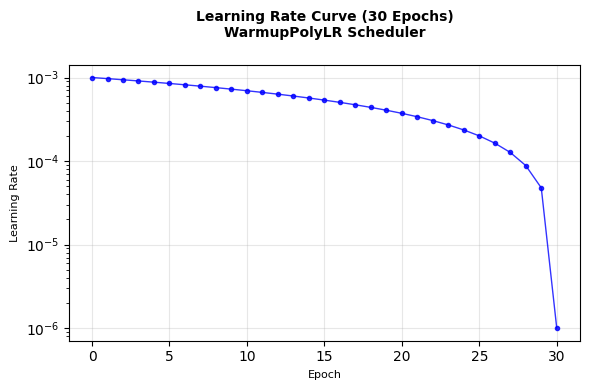


✅ Learning Rate 분석 완료!


In [3]:
# ==================== Learning Rate 변화 추적 및 시각화 ====================
import matplotlib.pyplot as plt
import numpy as np
import torch

print("=== Learning Rate 변화 분석 시작 ===")

# 더미 모델과 옵티마이저 생성 (실제 학습 설정과 동일하게)
print("📊 Learning Rate 변화 계산 중...")

class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = torch.nn.Linear(1, 1)
    def parameters(self):
        return [torch.nn.Parameter(torch.zeros(1))]

dummy_model = DummyModel()
optimizer = Make_Optimizer(dummy_model)
lr_scheduler = Make_LR_Scheduler(optimizer)

# 30 epoch 동안의 learning rate 변화 기록
epochs_list = []
lr_values = []

# 초기 learning rate 기록
current_lr = optimizer.param_groups[0]['lr']
epochs_list.append(0)
lr_values.append(current_lr)

# 각 epoch마다 scheduler step 실행하며 learning rate 기록
for epoch in range(1, epochs + 1):
    lr_scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    epochs_list.append(epoch)
    lr_values.append(current_lr)

print(f"✅ {epochs} epoch 동안의 Learning Rate 변화 계산 완료")

# Learning Rate 변화 그래프 생성
plt.figure(figsize=(6, 4))
plt.plot(epochs_list, lr_values, 'b-', linewidth=1, marker='o', markersize=3, alpha=0.8)
plt.title(f'Learning Rate Curve (30 Epochs)\n{lr_scheduler.__class__.__name__} Scheduler', 
          fontsize=10, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=8)
plt.ylabel('Learning Rate', fontsize=8)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # 로그 스케일로 표시

# Warmup 구간 표시 (있는 경우)
if hasattr(lr_scheduler, 'warmup_iters') and lr_scheduler.warmup_iters > 0:
    warmup_epochs = lr_scheduler.warmup_iters
    plt.axvline(x=warmup_epochs, color='red', linestyle='--', alpha=0.7, linewidth=2,
               label=f'Warmup End (Epoch {warmup_epochs})')
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()
plt.close()  # 메모리 절약을 위해 close

print(f"\n✅ Learning Rate 분석 완료!")


In [4]:
now = datetime.now()
Experiments_Time=now.strftime("%y%m%d_%H%M%S")
print('Experiment Start Time:',Experiments_Time)
eval_columns=['Experiment Time','Train Time', 'Dataset Name', 'Model Name', 'Val Loss', 'Test Loss', 'IoU', 'Dice',  'Precision', 'Recall', 'Total Params','Train-Predction Time']
df = pd.DataFrame(index=None, columns=eval_columns)
output_root = f'{output_root}/output_{Experiments_Time}'
os.makedirs(output_root, exist_ok = True)
seed = iteration = 1
for j, Dataset_Name in enumerate(Dataset_Name_list):
    print(f'Dataset: {Dataset_Name} ({j+1}/{len(Dataset_Name_list)})')
    control_random_seed(seed)
    Dataset_dir = Dataset_root+'/'+Dataset_Name
    Height, Width = (256, 256)
    in_channels = 3
    number_of_classes = number_of_classes_dict[Dataset_Name]
    BINARY_SEG = True if number_of_classes==2 else False
    exclude_background = EXCLUDE_BACKGROUND
    out_channels = 1 if BINARY_SEG else number_of_classes

    train_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/train/Originals/*"))
    train_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/train/Masks/*"))
    validation_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/val/Originals/*"))
    validation_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/val/Masks/*"))
    test_image_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/test/Originals/*"))
    test_target_path_list = natsort.natsorted(glob.glob(f"{Dataset_dir}/test/Masks/*"))
    print(f'train/val/test: {len(train_image_path_list)}/{len(validation_image_path_list)}/{len(test_image_path_list)}')

    # train_dataset = ImagesDataset(train_image_path_list, train_target_path_list, augment=False)
    train_dataset = ImagesDataset(train_image_path_list, train_target_path_list)
    validation_dataset = ImagesDataset(validation_image_path_list, validation_target_path_list)
    test_dataset = ImagesDataset(test_image_path_list, test_target_path_list)
    train_loader = SegDataLoader(
    train_dataset, batch_size=batch_size,
    num_workers=4, pin_memory=True, shuffle=True, drop_last=True, fill_last_batch=False,
    )
    validation_loader = SegDataLoader(
        validation_dataset, batch_size=batch_size, 
        num_workers=4, pin_memory=True,
    )
    test_loader = SegDataLoader(
        test_dataset, batch_size=batch_size, 
        num_workers=4, pin_memory=True,
    )

    print(f'{model_name}', end=' ')
    print(f'Dataset: {Dataset_Name}) ({j+1}/{len(Dataset_Name_list)})', end=' ')
    output_dir = output_root + f'/{model_name}_{Dataset_Name}'
    control_random_seed(seed)
    model=globals()[model_name](in_channels, out_channels)
    model = model.to(device)
    optimizer = Make_Optimizer(model)
    lr_scheduler = Make_LR_Scheduler(optimizer)
    criterion = Make_Loss_Function(number_of_classes)
    if SAVE_RESULT==True:
        os.makedirs(vis_root+f"/{Dataset_Name}", exist_ok=True)
    df = Execute_Experiment(model_name, model, Dataset_Name, train_loader, validation_loader, test_loader, 
                            optimizer, lr_scheduler, criterion, number_of_classes, df, epochs, device, output_dir,
                           BINARY_SEG, exclude_background, out_channels, seed, THRESHOLD, EARLY_STOP, SAVE_RESULT, vis_root+f"/{Dataset_Name}", Experiments_Time
                           )
    df.to_csv(output_root+'/'+f'{Project_Name}_'+Experiments_Time+'.csv', index=False, header=True, encoding="cp949")

Experiment Start Time: 250614_020129
Dataset: VOC (1/5)
train/val/test: 1747/583/583
submission_MicroUNetv6 Dataset: VOC) (1/5) Training Start Time: 250614_020129


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

1EP(250614_020143): T_Loss: 1.807909 V_Loss: 1.783218 IoU: 0.0037 Best Epoch: 1 Loss: 1.783218


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

2EP(250614_020157): T_Loss: 1.752970 V_Loss: 1.763728 IoU: 0.0030 Best Epoch: 2 Loss: 1.763728


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

3EP(250614_020211): T_Loss: 1.741247 V_Loss: 1.754126 IoU: 0.0029 Best Epoch: 3 Loss: 1.754126


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

4EP(250614_020225): T_Loss: 1.737343 V_Loss: 1.745771 IoU: 0.0048 Best Epoch: 4 Loss: 1.745771


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

5EP(250614_020239): T_Loss: 1.724830 V_Loss: 1.770668 IoU: 0.0040 


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

6EP(250614_020253): T_Loss: 1.718006 V_Loss: 1.738937 IoU: 0.0045 Best Epoch: 6 Loss: 1.738937


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

7EP(250614_020307): T_Loss: 1.710109 V_Loss: 1.740002 IoU: 0.0045 


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

8EP(250614_020320): T_Loss: 1.713012 V_Loss: 1.728195 IoU: 0.0051 Best Epoch: 8 Loss: 1.728195


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

9EP(250614_020334): T_Loss: 1.704963 V_Loss: 1.734422 IoU: 0.0045 


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

10EP(250614_020348): T_Loss: 1.706510 V_Loss: 1.735288 IoU: 0.0044 


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

11EP(250614_020402): T_Loss: 1.700156 V_Loss: 1.727472 IoU: 0.0048 Best Epoch: 11 Loss: 1.727472


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

12EP(250614_020416): T_Loss: 1.694265 V_Loss: 1.736051 IoU: 0.0050 


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

13EP(250614_020430): T_Loss: 1.706596 V_Loss: 1.725771 IoU: 0.0046 Best Epoch: 13 Loss: 1.725771


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

14EP(250614_020443): T_Loss: 1.690980 V_Loss: 1.722481 IoU: 0.0053 Best Epoch: 14 Loss: 1.722481


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

15EP(250614_020457): T_Loss: 1.690033 V_Loss: 1.721532 IoU: 0.0053 Best Epoch: 15 Loss: 1.721532


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

16EP(250614_020511): T_Loss: 1.690258 V_Loss: 1.717686 IoU: 0.0053 Best Epoch: 16 Loss: 1.717686


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

17EP(250614_020525): T_Loss: 1.689832 V_Loss: 1.723940 IoU: 0.0050 


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

18EP(250614_020539): T_Loss: 1.685014 V_Loss: 1.725256 IoU: 0.0054 


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

19EP(250614_020553): T_Loss: 1.681881 V_Loss: 1.724789 IoU: 0.0050 


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

20EP(250614_020607): T_Loss: 1.682317 V_Loss: 1.715701 IoU: 0.0055 Best Epoch: 20 Loss: 1.715701


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

21EP(250614_020621): T_Loss: 1.679584 V_Loss: 1.716117 IoU: 0.0057 


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

22EP(250614_020635): T_Loss: 1.676462 V_Loss: 1.716938 IoU: 0.0058 


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

23EP(250614_020649): T_Loss: 1.671584 V_Loss: 1.711832 IoU: 0.0063 Best Epoch: 23 Loss: 1.711832


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

24EP(250614_020703): T_Loss: 1.672716 V_Loss: 1.719971 IoU: 0.0059 


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

25EP(250614_020717): T_Loss: 1.671642 V_Loss: 1.711778 IoU: 0.0057 Best Epoch: 25 Loss: 1.711778


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

26EP(250614_020731): T_Loss: 1.661850 V_Loss: 1.715044 IoU: 0.0058 


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

27EP(250614_020745): T_Loss: 1.664209 V_Loss: 1.710123 IoU: 0.0064 Best Epoch: 27 Loss: 1.710123


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

28EP(250614_020759): T_Loss: 1.661760 V_Loss: 1.708641 IoU: 0.0064 Best Epoch: 28 Loss: 1.708641


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

29EP(250614_020813): T_Loss: 1.659775 V_Loss: 1.711950 IoU: 0.0063 


Training:   0%|          | 0/109 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/37 [00:00<?, ?batch/s]

30EP(250614_020827): T_Loss: 1.659583 V_Loss: 1.710150 IoU: 0.0063 
Test Start Time: 250614_020827


Test:   0%|          | 0/37 [00:00<?, ?batch/s]

Best Epoch: 28
Test(250614_021001): Loss: 1.691952 IoU: 0.0416 Dice: 0.0613 Precision: 0.0723 Recall: 0.1284
End 250614_021001
Dataset: ETIS (2/5)
train/val/test: 118/39/39
submission_MicroUNetv6 Dataset: ETIS) (2/5) Training Start Time: 250614_021001


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

1EP(250614_021002): T_Loss: 22.951868 V_Loss: 1.937849 IoU: 0.0382 Best Epoch: 1 Loss: 1.937849


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

2EP(250614_021003): T_Loss: 18.427893 V_Loss: 1.895336 IoU: 0.0382 Best Epoch: 2 Loss: 1.895336


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

3EP(250614_021004): T_Loss: 16.136662 V_Loss: 1.757817 IoU: 0.0320 Best Epoch: 3 Loss: 1.757817


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

4EP(250614_021005): T_Loss: 14.065314 V_Loss: 2.005830 IoU: 0.0157 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

5EP(250614_021006): T_Loss: 11.485248 V_Loss: 4.455776 IoU: 0.0145 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

6EP(250614_021006): T_Loss: 8.578169 V_Loss: 3.168722 IoU: 0.0253 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

7EP(250614_021007): T_Loss: 5.171435 V_Loss: 1.411826 IoU: 0.0521 Best Epoch: 7 Loss: 1.411826


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

8EP(250614_021008): T_Loss: 2.555405 V_Loss: 1.261881 IoU: 0.0517 Best Epoch: 8 Loss: 1.261881


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

9EP(250614_021009): T_Loss: 1.413473 V_Loss: 0.898453 IoU: 0.0723 Best Epoch: 9 Loss: 0.898453


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

10EP(250614_021010): T_Loss: 0.942646 V_Loss: 0.620627 IoU: 0.1171 Best Epoch: 10 Loss: 0.620627


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

11EP(250614_021011): T_Loss: 0.657280 V_Loss: 0.523994 IoU: 0.1226 Best Epoch: 11 Loss: 0.523994


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

12EP(250614_021012): T_Loss: 0.493811 V_Loss: 0.515199 IoU: 0.0835 Best Epoch: 12 Loss: 0.515199


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

13EP(250614_021013): T_Loss: 0.469464 V_Loss: 0.490180 IoU: 0.1179 Best Epoch: 13 Loss: 0.490180


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

14EP(250614_021014): T_Loss: 0.442024 V_Loss: 0.498110 IoU: 0.0874 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

15EP(250614_021015): T_Loss: 0.433331 V_Loss: 0.477159 IoU: 0.1534 Best Epoch: 15 Loss: 0.477159


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

16EP(250614_021016): T_Loss: 0.413824 V_Loss: 0.481521 IoU: 0.1397 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

17EP(250614_021017): T_Loss: 0.407094 V_Loss: 0.465527 IoU: 0.1897 Best Epoch: 17 Loss: 0.465527


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

18EP(250614_021018): T_Loss: 0.403868 V_Loss: 0.483844 IoU: 0.1901 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

19EP(250614_021019): T_Loss: 0.391755 V_Loss: 0.444990 IoU: 0.1901 Best Epoch: 19 Loss: 0.444990


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

20EP(250614_021019): T_Loss: 0.379627 V_Loss: 0.443621 IoU: 0.2067 Best Epoch: 20 Loss: 0.443621


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

21EP(250614_021020): T_Loss: 0.360587 V_Loss: 0.448803 IoU: 0.2104 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

22EP(250614_021021): T_Loss: 0.364238 V_Loss: 0.432942 IoU: 0.2084 Best Epoch: 22 Loss: 0.432942


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

23EP(250614_021022): T_Loss: 0.351128 V_Loss: 0.434618 IoU: 0.2130 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

24EP(250614_021023): T_Loss: 0.346225 V_Loss: 0.433301 IoU: 0.2164 


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

25EP(250614_021024): T_Loss: 0.339727 V_Loss: 0.431622 IoU: 0.2148 Best Epoch: 25 Loss: 0.431622


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

26EP(250614_021025): T_Loss: 0.327610 V_Loss: 0.426556 IoU: 0.2229 Best Epoch: 26 Loss: 0.426556


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

27EP(250614_021026): T_Loss: 0.329337 V_Loss: 0.424221 IoU: 0.2261 Best Epoch: 27 Loss: 0.424221


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

28EP(250614_021027): T_Loss: 0.328991 V_Loss: 0.419286 IoU: 0.2330 Best Epoch: 28 Loss: 0.419286


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

29EP(250614_021028): T_Loss: 0.324756 V_Loss: 0.417614 IoU: 0.2350 Best Epoch: 29 Loss: 0.417614


Training:   0%|          | 0/7 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/3 [00:00<?, ?batch/s]

30EP(250614_021029): T_Loss: 0.308942 V_Loss: 0.418356 IoU: 0.2366 
Test Start Time: 250614_021029


Test:   0%|          | 0/3 [00:00<?, ?batch/s]

Best Epoch: 29
Test(250614_021034): Loss: 0.399483 IoU: 0.2768 Dice: 0.3707 Precision: 0.4768 Recall: 0.3628
End 250614_021034
Dataset: CVPPP (3/5)
train/val/test: 486/162/162
submission_MicroUNetv6 Dataset: CVPPP) (3/5) Training Start Time: 250614_021034


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

1EP(250614_021037): T_Loss: 9.172565 V_Loss: 1.302185 IoU: 0.0329 Best Epoch: 1 Loss: 1.302185


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

2EP(250614_021039): T_Loss: 1.639220 V_Loss: 0.389415 IoU: 0.5686 Best Epoch: 2 Loss: 0.389415


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

3EP(250614_021042): T_Loss: 0.196761 V_Loss: 0.160544 IoU: 0.7687 Best Epoch: 3 Loss: 0.160544


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

4EP(250614_021044): T_Loss: 0.114016 V_Loss: 0.095872 IoU: 0.8325 Best Epoch: 4 Loss: 0.095872


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

5EP(250614_021047): T_Loss: 0.088731 V_Loss: 0.083165 IoU: 0.8391 Best Epoch: 5 Loss: 0.083165


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

6EP(250614_021049): T_Loss: 0.075510 V_Loss: 0.074344 IoU: 0.8596 Best Epoch: 6 Loss: 0.074344


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

7EP(250614_021052): T_Loss: 0.066775 V_Loss: 0.073604 IoU: 0.8577 Best Epoch: 7 Loss: 0.073604


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

8EP(250614_021054): T_Loss: 0.062737 V_Loss: 0.059841 IoU: 0.8779 Best Epoch: 8 Loss: 0.059841


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

9EP(250614_021057): T_Loss: 0.056125 V_Loss: 0.055874 IoU: 0.8843 Best Epoch: 9 Loss: 0.055874


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

10EP(250614_021059): T_Loss: 0.052401 V_Loss: 0.051294 IoU: 0.8923 Best Epoch: 10 Loss: 0.051294


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

11EP(250614_021102): T_Loss: 0.051790 V_Loss: 0.052546 IoU: 0.8906 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

12EP(250614_021105): T_Loss: 0.048677 V_Loss: 0.047860 IoU: 0.8977 Best Epoch: 12 Loss: 0.047860


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

13EP(250614_021107): T_Loss: 0.048038 V_Loss: 0.047453 IoU: 0.8979 Best Epoch: 13 Loss: 0.047453


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

14EP(250614_021110): T_Loss: 0.045196 V_Loss: 0.048662 IoU: 0.8983 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

15EP(250614_021112): T_Loss: 0.043941 V_Loss: 0.044611 IoU: 0.9040 Best Epoch: 15 Loss: 0.044611


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

16EP(250614_021114): T_Loss: 0.045383 V_Loss: 0.042946 IoU: 0.9061 Best Epoch: 16 Loss: 0.042946


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

17EP(250614_021117): T_Loss: 0.043138 V_Loss: 0.043099 IoU: 0.9065 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

18EP(250614_021119): T_Loss: 0.042804 V_Loss: 0.042941 IoU: 0.9066 Best Epoch: 18 Loss: 0.042941


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

19EP(250614_021122): T_Loss: 0.041813 V_Loss: 0.041689 IoU: 0.9083 Best Epoch: 19 Loss: 0.041689


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

20EP(250614_021124): T_Loss: 0.040643 V_Loss: 0.041106 IoU: 0.9097 Best Epoch: 20 Loss: 0.041106


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

21EP(250614_021127): T_Loss: 0.040921 V_Loss: 0.040200 IoU: 0.9119 Best Epoch: 21 Loss: 0.040200


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

22EP(250614_021129): T_Loss: 0.039581 V_Loss: 0.040150 IoU: 0.9116 Best Epoch: 22 Loss: 0.040150


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

23EP(250614_021132): T_Loss: 0.039863 V_Loss: 0.040143 IoU: 0.9120 Best Epoch: 23 Loss: 0.040143


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

24EP(250614_021135): T_Loss: 0.038892 V_Loss: 0.039696 IoU: 0.9124 Best Epoch: 24 Loss: 0.039696


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

25EP(250614_021137): T_Loss: 0.037793 V_Loss: 0.039214 IoU: 0.9132 Best Epoch: 25 Loss: 0.039214


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

26EP(250614_021140): T_Loss: 0.038948 V_Loss: 0.039371 IoU: 0.9139 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

27EP(250614_021142): T_Loss: 0.037585 V_Loss: 0.038307 IoU: 0.9150 Best Epoch: 27 Loss: 0.038307


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

28EP(250614_021145): T_Loss: 0.037515 V_Loss: 0.038617 IoU: 0.9142 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

29EP(250614_021147): T_Loss: 0.038499 V_Loss: 0.038449 IoU: 0.9148 


Training:   0%|          | 0/30 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/11 [00:00<?, ?batch/s]

30EP(250614_021150): T_Loss: 0.037990 V_Loss: 0.038811 IoU: 0.9138 
Test Start Time: 250614_021150


Test:   0%|          | 0/11 [00:00<?, ?batch/s]

Best Epoch: 27
Test(250614_021215): Loss: 0.038793 IoU: 0.9085 Dice: 0.9505 Precision: 0.9510 Recall: 0.9520
End 250614_021215
Dataset: CFD (4/5)
train/val/test: 70/24/24
submission_MicroUNetv6 Dataset: CFD) (4/5) Training Start Time: 250614_021215


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

1EP(250614_021216): T_Loss: 26.121943 V_Loss: 1.924240 IoU: 0.0091 Best Epoch: 1 Loss: 1.924240


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

2EP(250614_021216): T_Loss: 20.214090 V_Loss: 2.427627 IoU: 0.0091 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

3EP(250614_021217): T_Loss: 18.372566 V_Loss: 2.913097 IoU: 0.0091 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

4EP(250614_021218): T_Loss: 17.685240 V_Loss: 3.428648 IoU: 0.0091 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

5EP(250614_021219): T_Loss: 17.290264 V_Loss: 3.952421 IoU: 0.0091 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

6EP(250614_021219): T_Loss: 17.071592 V_Loss: 4.596402 IoU: 0.0091 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

7EP(250614_021220): T_Loss: 16.966537 V_Loss: 15.534978 IoU: 0.0091 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

8EP(250614_021221): T_Loss: 16.878242 V_Loss: 17.402791 IoU: 0.0091 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

9EP(250614_021222): T_Loss: 16.772089 V_Loss: 15.636186 IoU: 0.0078 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

10EP(250614_021222): T_Loss: 16.640444 V_Loss: 11.845896 IoU: 0.0013 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

11EP(250614_021223): T_Loss: 16.422207 V_Loss: 13.171708 IoU: 0.0024 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

12EP(250614_021224): T_Loss: 16.026079 V_Loss: 13.360537 IoU: 0.0033 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

13EP(250614_021225): T_Loss: 15.064831 V_Loss: 9.999495 IoU: 0.0038 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

14EP(250614_021225): T_Loss: 13.635332 V_Loss: 2.996185 IoU: 0.0030 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

15EP(250614_021226): T_Loss: 11.793968 V_Loss: 0.997403 IoU: 0.0029 Best Epoch: 15 Loss: 0.997403


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

16EP(250614_021227): T_Loss: 10.234085 V_Loss: 1.072948 IoU: 0.0041 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

17EP(250614_021228): T_Loss: 8.656306 V_Loss: 1.418076 IoU: 0.0059 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

18EP(250614_021228): T_Loss: 7.230952 V_Loss: 2.329606 IoU: 0.0074 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

19EP(250614_021229): T_Loss: 5.915208 V_Loss: 3.171065 IoU: 0.0067 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

20EP(250614_021230): T_Loss: 4.758314 V_Loss: 4.974735 IoU: 0.0050 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

21EP(250614_021231): T_Loss: 3.859302 V_Loss: 4.085940 IoU: 0.0043 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

22EP(250614_021231): T_Loss: 2.916530 V_Loss: 3.064014 IoU: 0.0048 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

23EP(250614_021232): T_Loss: 2.362735 V_Loss: 2.550508 IoU: 0.0054 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

24EP(250614_021233): T_Loss: 2.003894 V_Loss: 2.022649 IoU: 0.0071 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

25EP(250614_021234): T_Loss: 1.697221 V_Loss: 1.682154 IoU: 0.0071 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

26EP(250614_021234): T_Loss: 1.523456 V_Loss: 1.518944 IoU: 0.0097 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

27EP(250614_021235): T_Loss: 1.393888 V_Loss: 1.418010 IoU: 0.0108 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

28EP(250614_021236): T_Loss: 1.324577 V_Loss: 1.291906 IoU: 0.0105 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

29EP(250614_021237): T_Loss: 1.253568 V_Loss: 1.236995 IoU: 0.0102 


Training:   0%|          | 0/4 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/2 [00:00<?, ?batch/s]

30EP(250614_021237): T_Loss: 1.220212 V_Loss: 1.192883 IoU: 0.0101 
Test Start Time: 250614_021237


Test:   0%|          | 0/2 [00:00<?, ?batch/s]

Best Epoch: 15
Test(250614_021241): Loss: 1.530656 IoU: 0.0067 Dice: 0.0131 Precision: 0.0071 Recall: 0.1569
End 250614_021241
Dataset: CarDD (5/5)
train/val/test: 310/104/104
submission_MicroUNetv6 Dataset: CarDD) (5/5) Training Start Time: 250614_021241


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

1EP(250614_021243): T_Loss: 18.160753 V_Loss: 3.812654 IoU: 0.1186 Best Epoch: 1 Loss: 3.812654


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

2EP(250614_021244): T_Loss: 4.361392 V_Loss: 1.355142 IoU: 0.0754 Best Epoch: 2 Loss: 1.355142


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

3EP(250614_021246): T_Loss: 1.159752 V_Loss: 0.625086 IoU: 0.1740 Best Epoch: 3 Loss: 0.625086


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

4EP(250614_021248): T_Loss: 0.707545 V_Loss: 0.567882 IoU: 0.2082 Best Epoch: 4 Loss: 0.567882


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

5EP(250614_021250): T_Loss: 0.579172 V_Loss: 0.649038 IoU: 0.0589 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

6EP(250614_021252): T_Loss: 0.488484 V_Loss: 0.574611 IoU: 0.2557 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

7EP(250614_021253): T_Loss: 0.458821 V_Loss: 0.535182 IoU: 0.1808 Best Epoch: 7 Loss: 0.535182


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

8EP(250614_021255): T_Loss: 0.451046 V_Loss: 0.485632 IoU: 0.2625 Best Epoch: 8 Loss: 0.485632


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

9EP(250614_021257): T_Loss: 0.436866 V_Loss: 0.505509 IoU: 0.2745 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

10EP(250614_021259): T_Loss: 0.434447 V_Loss: 0.509629 IoU: 0.2676 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

11EP(250614_021300): T_Loss: 0.423595 V_Loss: 0.520286 IoU: 0.2900 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

12EP(250614_021302): T_Loss: 0.417585 V_Loss: 0.476970 IoU: 0.2626 Best Epoch: 12 Loss: 0.476970


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

13EP(250614_021304): T_Loss: 0.410337 V_Loss: 0.475932 IoU: 0.2872 Best Epoch: 13 Loss: 0.475932


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

14EP(250614_021306): T_Loss: 0.403408 V_Loss: 0.479564 IoU: 0.2993 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

15EP(250614_021307): T_Loss: 0.396737 V_Loss: 0.480495 IoU: 0.2997 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

16EP(250614_021309): T_Loss: 0.397582 V_Loss: 0.483995 IoU: 0.2945 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

17EP(250614_021311): T_Loss: 0.383153 V_Loss: 0.469856 IoU: 0.2955 Best Epoch: 17 Loss: 0.469856


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

18EP(250614_021313): T_Loss: 0.379265 V_Loss: 0.469248 IoU: 0.2775 Best Epoch: 18 Loss: 0.469248


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

19EP(250614_021315): T_Loss: 0.378226 V_Loss: 0.492155 IoU: 0.3058 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

20EP(250614_021316): T_Loss: 0.370885 V_Loss: 0.468524 IoU: 0.3092 Best Epoch: 20 Loss: 0.468524


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

21EP(250614_021318): T_Loss: 0.367539 V_Loss: 0.462653 IoU: 0.3035 Best Epoch: 21 Loss: 0.462653


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

22EP(250614_021320): T_Loss: 0.359111 V_Loss: 0.474306 IoU: 0.3125 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

23EP(250614_021322): T_Loss: 0.359461 V_Loss: 0.471246 IoU: 0.3021 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

24EP(250614_021324): T_Loss: 0.354096 V_Loss: 0.459513 IoU: 0.3075 Best Epoch: 24 Loss: 0.459513


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

25EP(250614_021325): T_Loss: 0.344482 V_Loss: 0.473273 IoU: 0.3053 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

26EP(250614_021327): T_Loss: 0.346188 V_Loss: 0.474387 IoU: 0.3102 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

27EP(250614_021329): T_Loss: 0.339518 V_Loss: 0.464354 IoU: 0.3035 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

28EP(250614_021331): T_Loss: 0.334091 V_Loss: 0.455515 IoU: 0.3139 Best Epoch: 28 Loss: 0.455515


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

29EP(250614_021332): T_Loss: 0.329313 V_Loss: 0.469754 IoU: 0.3085 


Training:   0%|          | 0/19 [00:00<?, ?batch/s]

Valiation:   0%|          | 0/7 [00:00<?, ?batch/s]

30EP(250614_021334): T_Loss: 0.325144 V_Loss: 0.462948 IoU: 0.3089 
Test Start Time: 250614_021334


Test:   0%|          | 0/7 [00:00<?, ?batch/s]

Best Epoch: 28
Test(250614_021350): Loss: 0.463883 IoU: 0.3002 Dice: 0.4309 Precision: 0.4536 Recall: 0.5135
End 250614_021350


In [5]:
# 우회를 위한 prefix 제거
model_name = model_name.replace('submission_', '')

In [6]:
# 결과 분석 및 데이터 로드
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# CSV 파일 읽기
results_df = pd.read_csv(output_root+'/'+f'{Project_Name}_'+Experiments_Time+'.csv', encoding='cp949')

print("\n=== 실험 결과 요약 ===")
print(f"모델: {results_df['Model Name'].unique()}")
print(f"\n=== 모델 파라미터 정보 ===")
if 'Total Params' in results_df.columns:
    total_params = results_df['Total Params'].iloc[1]  # 모든 실험에서 같은 모델 사용
    total_params = int(total_params.replace(',',''))
    print("총 파라미터 수: {:,}".format(total_params))

# 2. 각 데이터셋별 IoU 결과
print(f"\n=== 데이터셋별 IoU 결과 ===")
dataset_results = results_df[['Dataset Name', 'IoU', 'Dice', 'Precision', 'Recall']].copy()
dataset_results = dataset_results.round(4)
print(dataset_results.to_string(index=False))

# 3. Mean IoU 계산
mean_iou = results_df['IoU'].mean()
print(f"\n=== 전체 성능 요약 ===")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice: {results_df['Dice'].mean():.4f}")
print(f"Mean Precision: {results_df['Precision'].mean():.4f}")
print(f"Mean Recall: {results_df['Recall'].mean():.4f}")

# 상세 결과 테이블
print(f"\n=== 상세 실험 결과 ===")
display_df = results_df[['Dataset Name', 'Model Name', 'IoU', 'Dice', 'Precision', 'Recall', 'Total Params']].copy()
display_df = display_df.round(4)
print(display_df.to_string(index=False))



=== 실험 결과 요약 ===
모델: ['submission_MicroUNetv6']

=== 모델 파라미터 정보 ===
총 파라미터 수: 62,680

=== 데이터셋별 IoU 결과 ===
Dataset Name    IoU   Dice  Precision  Recall
         VOC 0.0416 0.0613     0.0723  0.1284
        ETIS 0.2768 0.3707     0.4768  0.3628
       CVPPP 0.9085 0.9505     0.9510  0.9520
         CFD 0.0067 0.0131     0.0071  0.1569
       CarDD 0.3002 0.4309     0.4536  0.5135

=== 전체 성능 요약 ===
Mean IoU: 0.3068
Mean Dice: 0.3653
Mean Precision: 0.3922
Mean Recall: 0.4227

=== 상세 실험 결과 ===
Dataset Name             Model Name    IoU   Dice  Precision  Recall Total Params
         VOC submission_MicroUNetv6 0.0416 0.0613     0.0723  0.1284       63,020
        ETIS submission_MicroUNetv6 0.2768 0.3707     0.4768  0.3628       62,680
       CVPPP submission_MicroUNetv6 0.9085 0.9505     0.9510  0.9520       62,680
         CFD submission_MicroUNetv6 0.0067 0.0131     0.0071  0.1569       62,680
       CarDD submission_MicroUNetv6 0.3002 0.4309     0.4536  0.5135       62,680


In [7]:
# Global CSV에 결과 저장 (파라미터 사이즈와 Mean IoU만)
global_csv_path = 'results.csv'
global_result = {
    'Model_Name': [model_name],
    'Experiment_Time': [Experiments_Time],
    'Total_Params': [total_params],
    'Mean_IoU': [mean_iou]
}
global_df = pd.DataFrame(global_result)

# 기존 global CSV가 있으면 읽어서 추가, 없으면 새로 생성
if os.path.exists(global_csv_path):
    existing_global_df = pd.read_csv(global_csv_path)
    global_df = pd.concat([existing_global_df, global_df], ignore_index=True)

global_df.to_csv(global_csv_path, index=False)
print(f"\n=== Global 결과 저장 완료 ===")
print(f"저장 경로: {global_csv_path}")
print(f"누적 실험 수: {len(global_df)}")

# Global CSV 내용 확인
print(f"\n=== Global CSV 현재 내용 ===")
print(global_df.to_string(index=False))



=== Global 결과 저장 완료 ===
저장 경로: results.csv
누적 실험 수: 30

=== Global CSV 현재 내용 ===
 Model_Name Experiment_Time  Total_Params  Mean_IoU
   Baseline   250612_020604       7763041  0.387735
   Baseline   250612_022650       7763041  0.385343
      LCNet   250612_031035        508258  0.258133
      LCNet   250612_032355        508258  0.274923
      LCNet   250612_033942        508258  0.179640
   Baseline   250612_232032       7763041  0.453180
     LEDNet   250613_004419        918105  0.120133
      SINet   250613_015805        212226  0.175864
      SINet   250613_021114        212226  0.150565
      LCNet   250613_125539        508258  0.202450
      LCNet   250613_132229        508258  0.139699
      LCNet   250613_155605        508258  0.139660
      LCNet   250613_193440        508258  0.341077
  MicroUNet   250613_195033          2148  0.087164
  MicroUNet   250613_200841          3452  0.167313
  MicroUNet   250613_202028         15100  0.231277
MicroUNetv2   250613_204355       

In [8]:
# ==================== Core Metrics CSV 저장 ====================
# Core metrics를 별도 CSV로 저장
core_metrics_path = f'{output_root}/core_metrics_{Experiments_Time}.csv'

core_metrics_data = pd.DataFrame({
    'Student ID': [student_id],
    'Model Name': [model_name],
    'Experiment Time': [Experiments_Time],
    'Mean IoU': [round(mean_iou, 4)],
    'Total Params': [total_params]
})

core_metrics_data.to_csv(core_metrics_path, index=False, encoding='utf-8')
print(f"\n=== Core Metrics CSV 저장 완료 ===")
print(f"저장 경로: {core_metrics_path}")
print(f"\nCore Metrics 내용:")
print(core_metrics_data.to_string(index=False))

# ==================== Detail Metrics CSV 저장 ====================
# 상세 결과 테이블 출력
# Core metrics를 별도 CSV로 저장
detail_metrics_path = f'{output_root}/detail_metrics_{Experiments_Time}.csv'

display_df = results_df[['Dataset Name', 'Model Name', 'IoU', 'Dice', 'Precision', 'Recall', 'Total Params']].copy()
display_df = display_df.round(4)
display_df['Total Params'] = display_df['Total Params'].str.replace(',','').astype(int)

display_df.to_csv(detail_metrics_path, index=False)
print(f"\n=== Detail Metrics CSV 저장 완료 ===")
print(f"저장 경로: {detail_metrics_path}")
print(f"\nDetail Metrics 내용:")
print(display_df.to_string(index=False))


=== Core Metrics CSV 저장 완료 ===
저장 경로: output/output_250614_020129/core_metrics_250614_020129.csv

Core Metrics 내용:
Student ID  Model Name Experiment Time  Mean IoU  Total Params
  20221555 MicroUNetv6   250614_020129    0.3068         62680

=== Detail Metrics CSV 저장 완료 ===
저장 경로: output/output_250614_020129/detail_metrics_250614_020129.csv

Detail Metrics 내용:
Dataset Name             Model Name    IoU   Dice  Precision  Recall  Total Params
         VOC submission_MicroUNetv6 0.0416 0.0613     0.0723  0.1284         63020
        ETIS submission_MicroUNetv6 0.2768 0.3707     0.4768  0.3628         62680
       CVPPP submission_MicroUNetv6 0.9085 0.9505     0.9510  0.9520         62680
         CFD submission_MicroUNetv6 0.0067 0.0131     0.0071  0.1569         62680
       CarDD submission_MicroUNetv6 0.3002 0.4309     0.4536  0.5135         62680


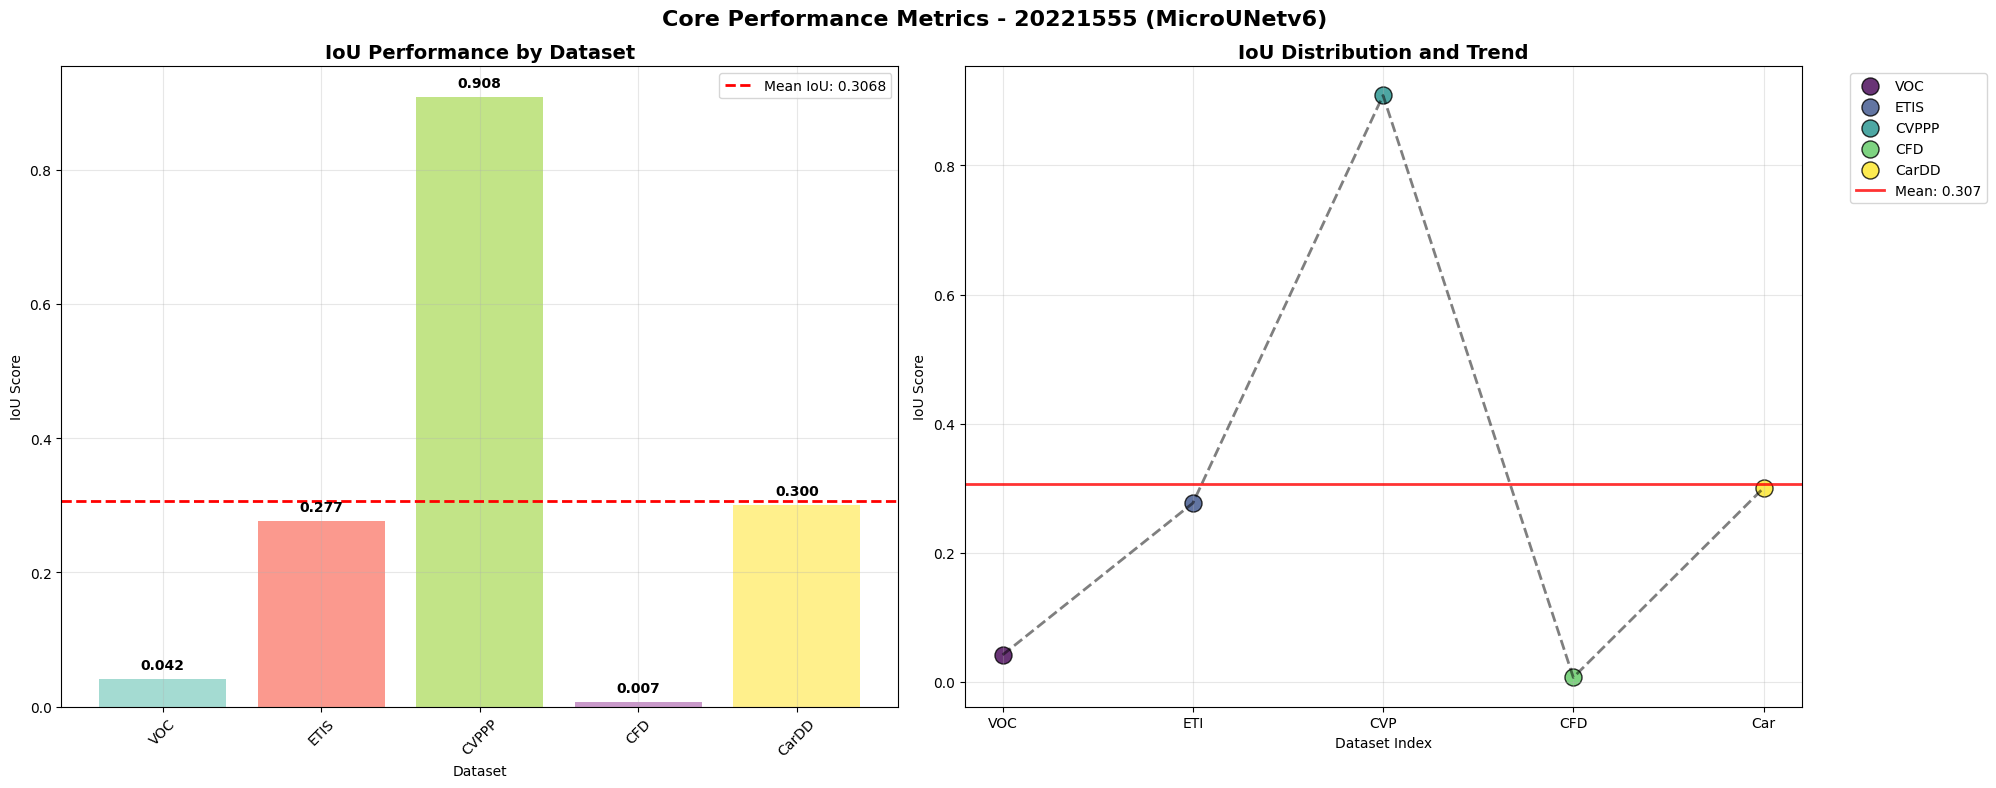

In [9]:
# ==================== 첫 번째 장: 핵심 지표 시각화 ====================
plt.figure(figsize=(20, 8))
plt.suptitle(f'Core Performance Metrics - {student_id} ({model_name})', fontsize=16, fontweight='bold')

# 1-1. 각 데이터셋별 IoU (바 차트)
plt.subplot(1, 2, 1)
colors = plt.cm.Set3(np.linspace(0, 1, len(results_df)))
bars = plt.bar(results_df['Dataset Name'], results_df['IoU'], color=colors, alpha=0.8)
plt.axhline(y=mean_iou, color='red', linestyle='--', linewidth=2, label=f'Mean IoU: {mean_iou:.4f}')
plt.title('IoU Performance by Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Dataset')
plt.ylabel('IoU Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 각 바 위에 수치 표시
for bar, value in zip(bars, results_df['IoU']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 1-2. IoU 분포 (레이더 차트 스타일)
plt.subplot(1, 2, 2)
datasets = results_df['Dataset Name'].tolist()
iou_scores = results_df['IoU'].tolist()

# 색상 맵 생성
colors = plt.cm.viridis(np.linspace(0, 1, len(datasets)))

for i, (dataset, iou, color) in enumerate(zip(datasets, iou_scores, colors)):
    plt.scatter(i, iou, s=150, c=[color], alpha=0.8, label=dataset, edgecolors='black', linewidth=1)

plt.plot(range(len(datasets)), iou_scores, 'k--', alpha=0.5, linewidth=2)
plt.axhline(y=mean_iou, color='red', linestyle='-', alpha=0.8, linewidth=2,
            label=f'Mean: {mean_iou:.3f}')
plt.title('IoU Distribution and Trend', fontsize=14, fontweight='bold')
plt.xlabel('Dataset Index')
plt.ylabel('IoU Score')
plt.xticks(range(len(datasets)), [d[:3] for d in datasets])  # 줄여서 표시
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_root+'/'+f'core_performance_{Experiments_Time}.png')
plt.show()

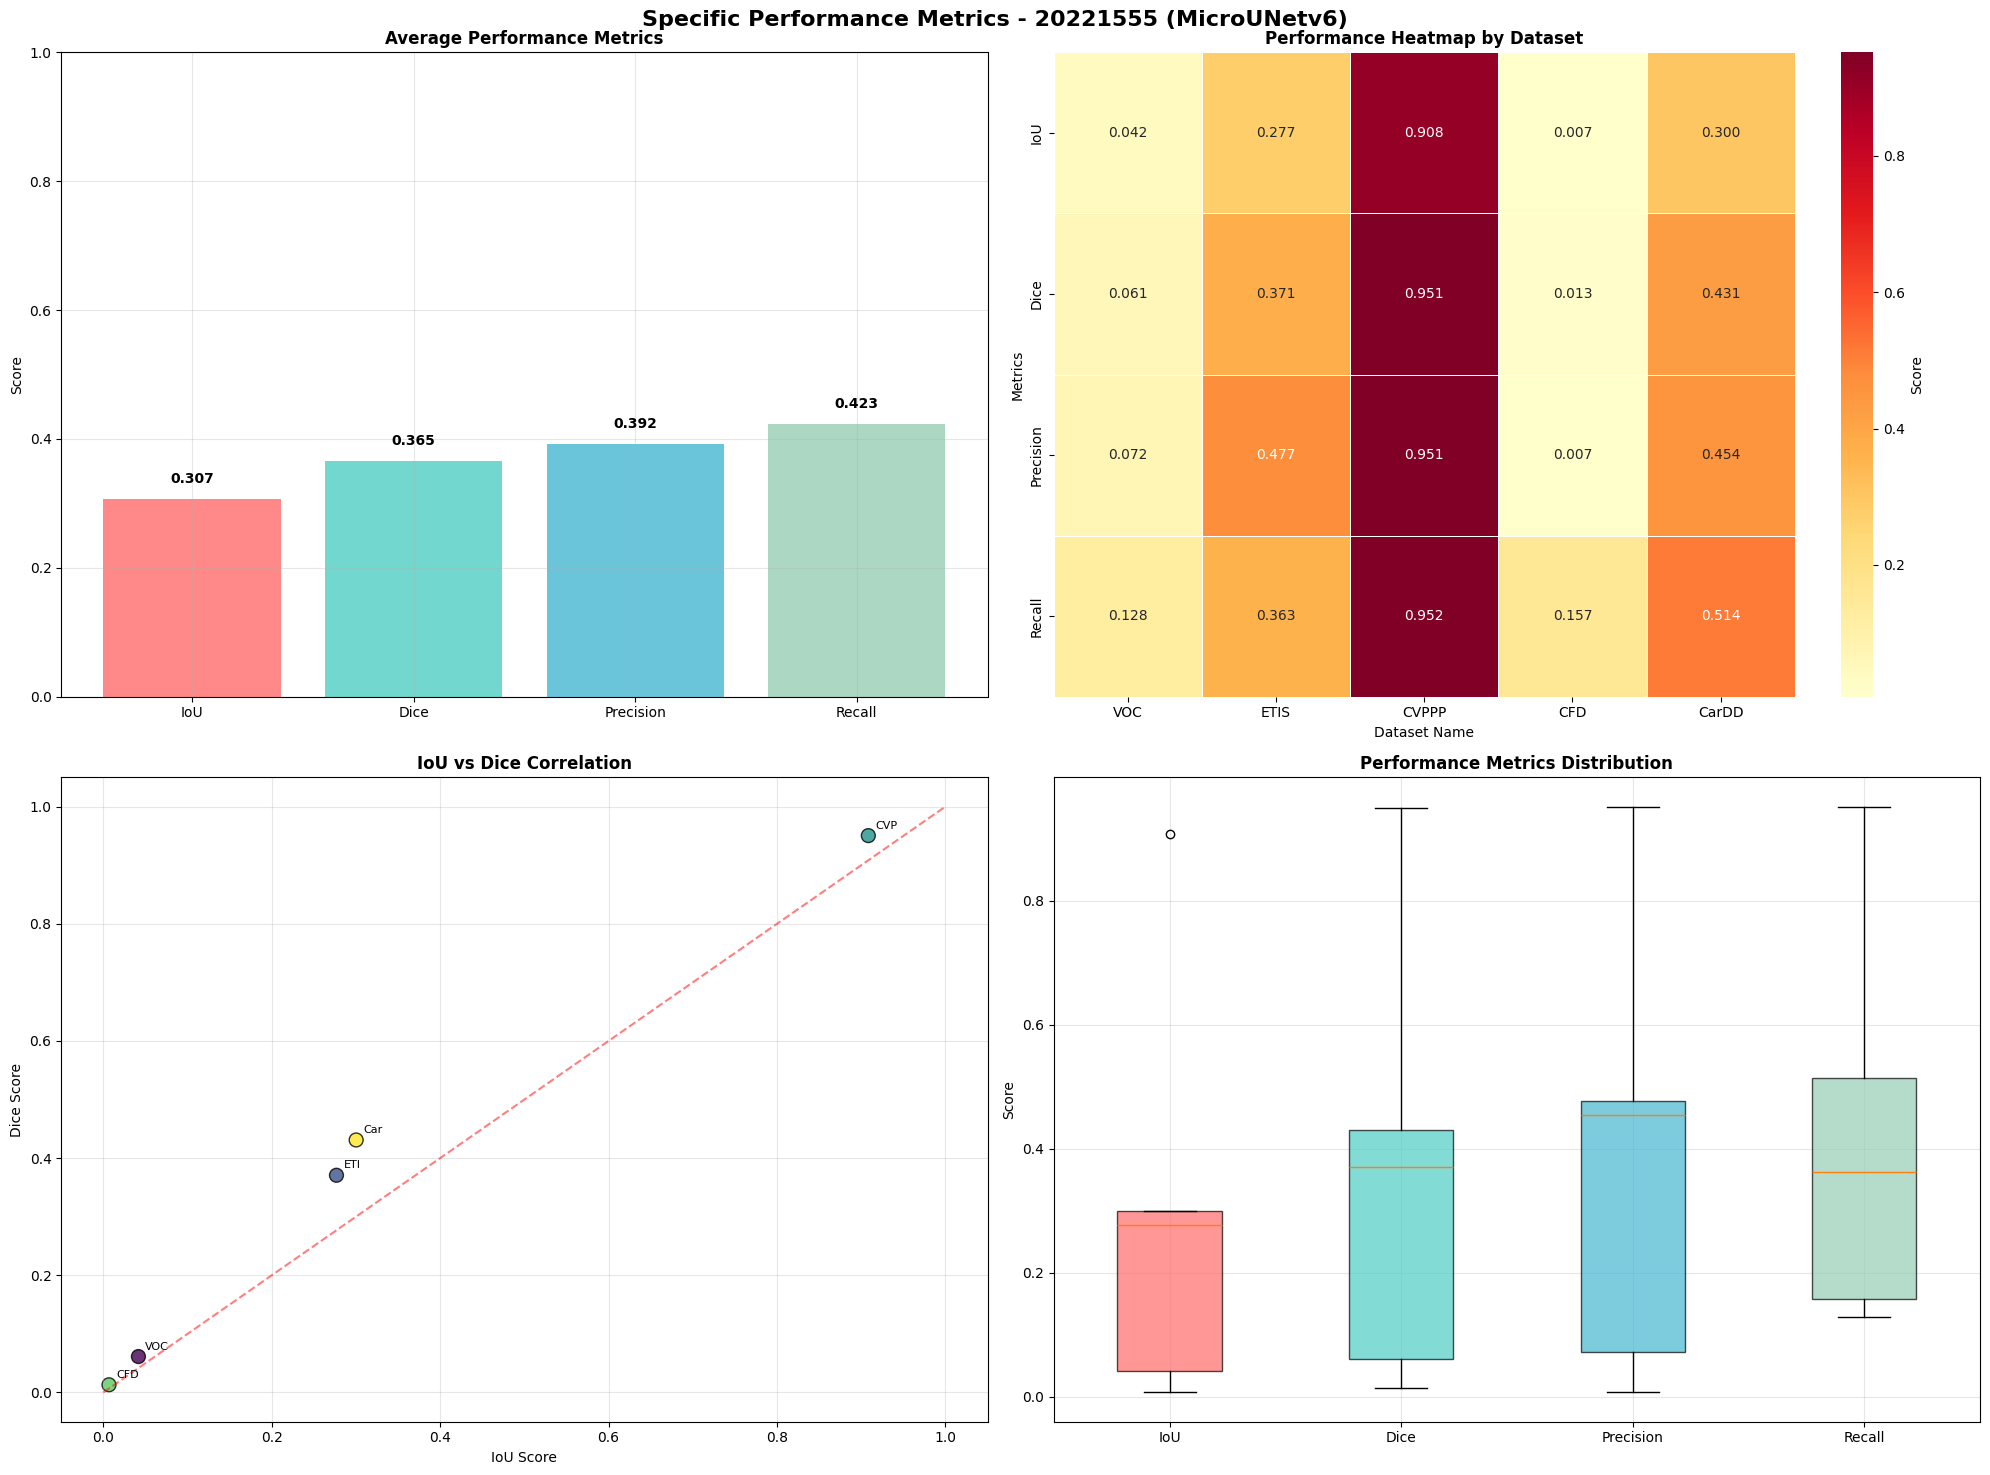

In [10]:
# ==================== 두 번째 장: 상세 분석 ====================
plt.figure(figsize=(20, 15))
plt.suptitle(f'Specific Performance Metrics - {student_id} ({model_name})', fontsize=16, fontweight='bold')

# 2-1. 전체 성능 지표 비교
plt.subplot(2, 2, 1)
metrics = ['IoU', 'Dice', 'Precision', 'Recall']
values = [results_df[metric].mean() for metric in metrics]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(metrics, values, color=colors, alpha=0.8)
plt.title('Average Performance Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# 각 바 위에 수치 표시
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 2-2. 데이터셋별 성능 히트맵
plt.subplot(2, 2, 2)
heatmap_data = results_df[['IoU', 'Dice', 'Precision', 'Recall']].T
heatmap_data.columns = results_df['Dataset Name']

sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.3f', 
            cbar_kws={'label': 'Score'}, linewidths=0.5)
plt.title('Performance Heatmap by Dataset', fontsize=12, fontweight='bold')
plt.ylabel('Metrics')

# 2-3. IoU vs Dice 상관관계
plt.subplot(2, 2, 3)
plt.scatter(results_df['IoU'], results_df['Dice'], c=range(len(results_df)), 
           cmap='viridis', s=100, alpha=0.8, edgecolors='black')
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)  # 대각선
plt.xlabel('IoU Score')
plt.ylabel('Dice Score')
plt.title('IoU vs Dice Correlation', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 각 점에 데이터셋 이름 표시
for i, dataset in enumerate(results_df['Dataset Name']):
    plt.annotate(dataset[:3], (results_df['IoU'].iloc[i], results_df['Dice'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# 2-4. 성능 지표별 분포
plt.subplot(2, 2, 4)
metrics_data = []
metrics_labels = []
for metric in ['IoU', 'Dice', 'Precision', 'Recall']:
    metrics_data.append(results_df[metric].tolist())
    metrics_labels.append(metric)

box_plot = plt.boxplot(metrics_data, labels=metrics_labels, patch_artist=True)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Performance Metrics Distribution', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_root+'/'+f'detail_performance_{Experiments_Time}.png')
plt.show()


In [11]:
# === 마지막 셀: 실험 내역 요약 & Markdown 저장 (샘플 이미지, 그래프, Core/Detail CSV 테이블 포함) ===
import glob, importlib.util, torch
from pathlib import Path
from IPython.display import Markdown, display
import pandas as pd

# 1) Performance Metrics
metrics_summary = {
    'Mean IoU': mean_iou,
    'Mean Dice': results_df['Dice'].mean(),
    'Mean Precision': results_df['Precision'].mean(),
    'Mean Recall': results_df['Recall'].mean(),
    'Total Params': total_params
}

# 2) 샘플 이미지 (최대 4개)
sample_images = glob.glob(f"{vis_root}/*/*.png")[:4]

# 3) 분석용 그래프 이미지 (output_root/*.png)
graph_images = glob.glob(f"{output_root}/*.png")

# 4) Core & Detail CSV 경로 자동 탐색
csv_files = glob.glob(f"{output_root}/*.csv")
core_csv_path   = next((p for p in csv_files if 'core'   in Path(p).name.lower()), None)
detail_csv_path = next((p for p in csv_files if 'detail' in Path(p).name.lower()), None)

# 5) CSV 읽기
core_df   = pd.read_csv(core_csv_path)   if core_csv_path   else pd.DataFrame()
detail_df = pd.read_csv(detail_csv_path) if detail_csv_path else pd.DataFrame()

# 6) training_args.py 동적 로드
spec = importlib.util.spec_from_file_location('training_args', 'training_args.py')
training_args = importlib.util.module_from_spec(spec)
spec.loader.exec_module(training_args)

# 7) 더미 모델 생성 후 옵티마이저/스케줄러/손실 함수 인스턴스
class _Dummy(torch.nn.Module):
    def parameters(self): return [torch.nn.Parameter(torch.zeros(1))]
dummy = _Dummy()
opt     = training_args.Make_Optimizer(dummy)
sch     = training_args.Make_LR_Scheduler(opt)

# Binary와 Multiclass 두 경우 모두 생성
loss_fn_binary = training_args.Make_Loss_Function(2)    # Binary case (클래스 수 = 2)
loss_fn_multi  = training_args.Make_Loss_Function(21)   # Multiclass case (VOC 21클래스)

# 8) 하이퍼파라미터 추출
opt_params = {k: v for k,v in opt.defaults.items() if k in ('lr','momentum','weight_decay','betas','eps')}
sch_params = {
    'type':      sch.__class__.__name__,
    'T_max':     getattr(sch, 'T_max', None),
    'warmup':    getattr(sch, 'warmup_iters', None),
    'eta_min':   getattr(sch, 'eta_min', None),
    'power':     getattr(sch, 'power', None),
}
# Binary와 Multiclass loss function 정보 추출
def extract_loss_params(loss_fn, case_name):
    params = {'type': loss_fn.__class__.__name__, 'case': case_name}
    for attr in ('alpha','gamma','weight','ignore_index','mode'):
        if hasattr(loss_fn, attr):
            params[attr] = getattr(loss_fn, attr)
    return params

loss_params_binary = extract_loss_params(loss_fn_binary, 'Binary (2 classes)')
loss_params_multi = extract_loss_params(loss_fn_multi, 'Multiclass (21 classes)')

# 9) Markdown 조립
md_lines = [
    '# 📝 실험 내역 요약',
    '## ▶ Performance Metrics'
]
for k,v in metrics_summary.items():
    if k == 'Total Params':
        md_lines.append(f"- **{k}**: `{v:,}`")  # 쉼표 형식으로 표시
    else:
        md_lines.append(f"- **{k}**: `{v:.4f}`")

# 그래프 이미지
md_lines += ['', '## ▶ 분석용 그래프']
for img in graph_images:
    img_name = Path(img).name
    md_lines.append(f"![{img_name}]({img_name})")

# Core CSV 테이블
if not core_df.empty:
    md_lines += ['', '## ▶ Core Metrics']
    # DataFrame.to_markdown() 로 생성된 텍스트를 한 줄씩 추가
    md_lines += core_df.to_markdown(index=False).split('\n')

# Detail CSV 테이블
if not detail_df.empty:
    md_lines += ['', '## ▶ Detail Metrics']
    md_lines += detail_df.to_markdown(index=False).split('\n')

# Hyperparameters
md_lines += ['', '## ▶ Hyperparameters']
md_lines.append(f"### Optimizer ({opt.__class__.__name__})")
for k,v in opt_params.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_lines.append(f"### Scheduler ({sch_params.pop('type')})")
for k,v in sch_params.items():
    md_lines.append(f"- `{k}`: `{v}`")

# Loss Functions (Binary & Multiclass)
md_lines.append("### Loss Functions")

md_lines.append(f"#### Binary Case ({loss_params_binary.pop('type')})")
for k,v in loss_params_binary.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_lines.append(f"#### Multiclass Case ({loss_params_multi.pop('type')})")
for k,v in loss_params_multi.items():
    md_lines.append(f"- `{k}`: `{v}`")

md_text = '\n'.join(md_lines)

# 10) 화면에 출력
#display(Markdown(md_text))

# 11) Markdown 파일로 저장
output_dir = Path(output_root)
output_dir.mkdir(parents=True, exist_ok=True)
md_path = output_dir / f"experiment_summary_{Experiments_Time}.md"
md_path.write_text(md_text, encoding='utf-8')

print(f"✅ Markdown 요약이 저장되었습니다: {md_path}")


✅ Markdown 요약이 저장되었습니다: output/output_250614_020129/experiment_summary_250614_020129.md


In [12]:
import requests

end_time = time.time()
elapsed_time = end_time - start_time
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

webhook_url = "https://discord.com/api/webhooks/1382936206731640912/FnHMkJjZo5UrE-ZXevPA9SIP-a-GRswUHb4jb4gjIsD7_McJ_ZR-h-rHm920ON-hHfIn"

payload = {
    "content": f'{student_id}의 {model_name} 학습 완료!\n소요 시간: {minutes}분 {seconds}초\nMean IoU: {mean_iou:.4f}'
}

requests.post(webhook_url, json=payload)

<Response [204]>